### ID3 Implemented from scratch with python
** some basic pandas and nupmpy utility functions are used

### Utility functions

Here I tried to avoid pandas utility functions and implemented many of them from scracth.

1. get_possible_labels
2. get_target_label_count
3. get_most_common
4. get_df_with_label

In [1]:
import pandas as pd
import sys
import numpy as np
import csv
from copy import deepcopy
sys.__stdout__=sys.stdout
use_pandas=True

def get_attr_names(df):
    return list(df.columns.values)

def get_possible_labels(examples,attr_name):     #getting possible labels of a attribute
    if use_pandas==False:
        attr_column=examples[attr_name]
        labels=[]
        for m in attr_column:
            if m not in labels:
                labels.append(m)
        return(labels)
    else :
        return examples[attr_name].unique()

def get_target_label_counts(target_attr,target_labels): #getting target label counts of a dataset
    if use_pandas==False:
        counts={}
        for label in target_labels:
            counts[label]=0
        for j in target_attr.index:
                target_val=target_attr[j]
                for label in target_labels:
                    if target_val==label:
                        counts[label]=counts[label]+1
        return counts
    else:
        return dict(target_attr.value_counts())
    
def get_most_common(counts):
    #if use_pandas == False:
        counts
        most_common=''
        max_count=0
        for kk,vv in counts.items():
            if int(vv)>max_count:
                   most_common=kk
                   max_count=vv
        return most_common
    
        
    
def get_df_with_label(examples,target_attr,attr_name,label):                        
    
    if use_pandas==False:
        attr_attr=examples.loc[:,attr_name]                                  
        ret=[]
        for index in attr_attr.index:
            if attr_attr[index]!=label:
                ret.append(index)
        examplesVi=examples.drop(ret,axis=0)
        target_attrVi=target_attr.drop(ret)
        
    else :
        _df=deepcopy(examples)
        _df['target']=deepcopy(target_attr)
        gp=_df.groupby(attr_name)
        _df=gp.get_group(label)
        target_attrVi=_df['target']
        examplesVi=_df.drop('target',axis=1)
    return examplesVi,target_attrVi


### Data discretization block

1. Entropy based discretization.
2. Quantile based discretization.

I will try both in thios project.

Below I tried to implement entropy or information gain based discretization.

1. get_thersholds
2. get_best_Split
3. relabel attributes
4. Discretize

In [2]:
def get_thrsholds(df,attr_name,target_attr):
        df[target_name]=target_attr
        sorted_df=df.sort_values(attr_name,axis=0).reset_index(drop=False)               #Sorting value
        old_index=sorted_df.index.values
        sorted_target=sorted_df[target_name].values
        
        prev_values=sorted_target[0:2] #saving first value as previous value
        thrs_val=[]
        #import pdb;pdb.set_trace()
        for index in range(2,len(sorted_target)):
                 
            curr_val=sorted_target[index]
            prev_values=sorted_target[index-2:index]                                                             #saving values until any change in labels
            if curr_val not in prev_values: 
                val=df.loc[old_index[index],attr_name]                           #getting value of the threshold point 
                if val not in(thrs_val):                              #checking duplicate
                    thrs_val.append(val)                                
                

        print(attr_name,thrs_val)
        return thrs_val                                       #returning threshold values and index
                
        #df get_splitted_gain


def best_split(df,attr_name,target_attr,thrs_val):
        df_left=df
        df_right=df
        wg_ent_sum=0
        total_items=(len(df))
        max_gain=0
        best_thr=0
        tg_label_count=get_target_label_counts(target_attr,target_labels)   #getting target labels counts
        ent_s=entropy(tg_label_count)
        #if len(thrs_val)>200:
        #    thrs_val[0]=np.mean(thrs_val)
        #    thrs_val=thrs_val[:1]
        for val in thrs_val:                                                ####iteration over each threshold value
            df_left=df
            df_right=df
            #val=thrs_val[0]
            #for index,row in df.iterrows():                                 ####spliting for a threshold value
            filt_left=df_left[attr_name]>=val
            filt_right=df_right[attr_name]<val
            df_left=df_left[filt_left]
            df_right=df_right[filt_right]
            df_list=[df_left,df_right]
            wg_ent_sum=0
            for sub_df in df_list:                                          #ierating over splited df
                target_attrVi=sub_df[target_name]
                tg_label_count=get_target_label_counts(target_attrVi,target_labels)
                ent=entropy(tg_label_count)
                no_items=len(target_attrVi)
                wg_ent_sum+=(no_items/total_items)*ent                      ####Getting weighted sum for splited data
            #print(ent_s,wg_ent_sum)
            gain=ent_s-wg_ent_sum                                           ####Getting gain
            if gain>max_gain:
                max_gain=gain
                best_thr=val                                                ####Getting thresh value with max gain
            #print(gain,val,best_thr)
        return best_thr
        
def relabel_attr(df,attr_name,best_thr):                                    
    new_df=[]
    for index,row in df.iterrows():
        #print(df.loc[index,attr_name])
        if (df.loc[index,attr_name]>best_thr):                          #Labeling values greater than threshold with descriptive string
                new_df.append(attr_name+'>='+str(best_thr))
        if (df.loc[index,attr_name]<=best_thr):                         #Labeling values less than threshold with descriptive string
                new_df.append(attr_name+'<'+str(best_thr))
    return new_df

def discretize(df,attr_names,target_attr):
    new_dict={}
    max_label=25
    for attr_name in attr_names:
        lb=get_possible_labels(df,attr_name)
        if(len(lb)>max_label) and df.dtypes[attr_name] !='object':
            #print(attr_name)
            thrs_val=get_thrsholds(df,attr_name,target_attr)
            best_thr=best_split(df,attr_name,target_attr,thrs_val)
            new_attr=relabel_attr(df,attr_name,best_thr)
            new_dict[attr_name]=new_attr
        else:
            labels=get_possible_labels(df,attr_name)
            lb_num=len(labels)
            if lb_num<=max_label:
                new_dict[attr_name]=list(df[attr_name])
    #new_dict[target_name]=list(df.loc[:,target_name])
    #print(new_dict)
    new_df=pd.DataFrame(new_dict)
    return(new_df)

### ID3 Funtions
1. Entropy
2. Gain
3. ID3
4. build tree
5. predict

In [3]:
def entropy(counts):
    total=0
    ent=0
    counts=list(counts.values())
    total=np.sum(counts)
    if total==0:
        return ent
    for val in counts:
        p=val/total
        if p!=0:
            ent-=1*p*np.log2(p)
    return ent

def gain(examples,attr_name,target_attr,target_labels):

    tg_label_count=get_target_label_counts(target_attr,target_labels)            #Getting label(+/-/others) count for dataset/subset
    ent_s=entropy(tg_label_count)                                                #Getting entropy for the dataset/subset
    total_items=len(examples)                                                      #getting total items count in attrumn(attribute)
    gain=0
    split_info=0
    labels=get_possible_labels(examples,attr_name)                                  #Getting possible labels for the attribute
    for i in range(len(labels)):
        _,target_attrVi=get_df_with_label(examples,target_attr,attr_name,labels[i]) #extract subset with label given
        tg_label_count=get_target_label_counts(target_attrVi,target_labels)         #Getting label(+/-/others) count for dataset/subset                                                                    #Running iteration over splitted labels

        ent=entropy(tg_label_count)                                                 #Getting entropy of each split
        no_of_items=len(target_attrVi)                                                 #weighted sum of entropies of splits
        ratio=no_of_items/total_items
        gain=gain+ent*(ratio)

        
        if ratio!=0:
            split_info-=(ratio*np.log2(ratio))                           #Getting weighted sum of split info
            
    gain=ent_s-gain                                                                #Getting information gain               
    if split_info!=0:
        gain_ratio=gain/split_info                                          
    #print('Log ....',attr_name,ent_s,gain)
    return split_info,gain





def ID3(examples,target_attr,attr_names):
    global summary,res,most_common
    
    tg_label_count=get_target_label_counts(target_attr,target_labels)              ###Getting target label counts
    tg_labels=list(tg_label_count.keys())
    most_common=get_most_common(tg_label_count)
    
    if len(tg_labels)==1:
           return tg_labels[0]
    
    
   
    max_gain=-1                                                                     ###Getting attribute with highest gain
    attr_name=''
    for i in range(len(attr_names)):                                                 
        _,gain_value= gain(examples,attr_names[i],target_attr,target_labels)
        if gain_value>max_gain:
            max_gain=gain_value
            attr_name=attr_names[i]
    #print('attr_name',attr_name)
    labels=get_possible_labels(examples,attr_name)                                      ###Getting possible labels for bes attribute
    #print('labels',labels)
    for label in labels:
        examplesVi,target_attrVi=get_df_with_label(examples,target_attr,attr_name,label)###Getting new subset of dataset
        examplesVi=examplesVi.drop(attr_name,axis=1)                            
        res.append(attr_name)                                                           ###returning attr_name,label pair
        res.append(label)
        attr_names=get_attr_names(examplesVi)
        if len(attr_names)==0:# len(target_attrVi)>=2:                                    ###Checking for empty datasets                                                                                         #Getting most common label
            return most_common
        else:
            ret=ID3(examplesVi,target_attrVi,attr_names)                                ###Calling ID3
            if ret !=None:
                res.append(target_name)
                res.append(ret)
                summary.append(res)
                res=[]
    return 


#print('ret',summary)



In [4]:
def build_tree(summary):
    root=summary[0][0]
    for k in range(len(summary)):
        if summary[k][0]==root:
            temp=summary[k]
        if summary[k][0]!=root:
            #print(temp)
            for t in range(len(temp)):
                if temp[t]==summary[k][0]:
                    temp=temp[:t]
                    break
            summary[k]=temp+summary[k]
        #print(summary[k])
def predict(test_sample,summary):
    #import pdb;pdb.set_trace();
    for i in range(len(summary)):
            m=len(summary[i])                      #Taking a rule
            for j in range(m//2):
                attr=summary[i][2*j]               #Taking a attr
                label=summary[i][2*j+1]            #Taking corresponding label
                
                if attr!=target_name:               #last node is not reached
                   if test_sample[attr] != label:   #Checking up to this node test sample is following the rule or not ?
                        pred_label=summary[i][-1]  
                        break
                else :                              # Last Node break
                    pred_label=label
                    break
                        
                                                   #if not break and go for next rule
            if attr == target_name:                #if test data satisfy have all the attr>> label in rule
                pred_label=label
                break                              #setting result according to rule
    return pred_label,i


def predict_all(test_samples,true_labels,summary,verbose=True):
    result_log={'right' : [],'wrong' : [],'Predictions' : [],'True Label' : []}
    acc=0
    wrong=0
    if verbose==True:
        print('--------------------------------')
        print(len(test_samples))
    for kk in range(len(test_samples)):
        test_sample=test_samples.loc[kk,:]
        pred_label,rule_id=predict(test_sample,summary)
        true_label=true_labels[kk]
        if true_label==pred_label:        #Checking results validity from true label
                acc=acc+1
                tp[pred_label]+=1
                #break
        else: wrong+=1
        if true_label!=pred_label:
                 tn[pred_label]+=1
                 fp[true_label]+=1  
        result_log['right'].append(acc)
        result_log['wrong'].append(wrong)
        result_log['Predictions'].append(pred_label)
        result_log['True Label'].append(true_label)
        
        
    accuracy=acc/len(test_df)*100
    
    for label in target_labels:
            try:recall[label]=tp[label]/(tp[label]+tn[label])
            except:0
            try:precision[label]=tp[label]/(tp[label]+fp[label])
            except:0
            if verbose==True:
                print(label,'precision',precision[label],'recall',recall[label])
    
    if verbose==True: print('Summary : ','correct:',acc, 'total :',len(test_df),'accuracy :',acc/len(test_df)*100,'%')
    return accuracy,pd.DataFrame(result_log)

### Main Loop

In [5]:
#df=pd.read_csv('Dataset/iris.csv',delimiter=',' )#,names=names)
df=pd.read_csv('Dataset/titanic.csv',delimiter=',' )#,names=names)
df=df.drop(['Ticket','Cabin'],axis=1)

#df=df.sample(frac=1).reset_index(drop=True)
df=df.fillna(df.mean())
df=df.replace(np.NaN,'nan')

summary=[]
res=[]
attr_names=get_attr_names(df)
target_name='Survived'#attr_names[-1]
target_attr=df[target_name]
target_labels=get_possible_labels(df,target_name)
df=df.drop(target_name,axis=1)
tind=attr_names.index(target_name)
attr_names=attr_names[:tind]+attr_names[tind+1:]

info_gain_discretize=True
quantile_discretize=False

if info_gain_discretize:
    df=discretize(df,attr_names,target_attr)
if quantile_discretize:
    for attr in attr_names:
        if df[attr].dtype!=object:
            temp=pd.qcut(df[attr],4,duplicates="drop")
            df[attr]=temp
            
            

print(attr_names,target_labels)
print(df.head(5))
#input('Press Enter to continue:')


split=int(0.80*len(df))
#split=0
train_df=df.loc[:split,:]
train_target_attr=target_attr.loc[:split]

test_df=df.loc[split:,:].reset_index(drop=True)
test_target=target_attr.loc[split:].reset_index(drop=True)



ID3(train_df,train_target_attr,attr_names)
build_tree(summary)

fp={}
tn={}
tp={}
precision={}
recall={}
for label in target_labels:
    fp[label]=0
    tn[label]=0
    tp[label]=0
    recall[label]=0
    precision[label]=0
    
    
accuracy,result_log=predict_all(test_df,test_target,summary)
print('No of rule trees',len(summary))
_result_log=result_log.copy()
_result_log['Predictions']=result_log['Predictions'].map({0:'No',1:'Yes'})
_result_log['True Label']=result_log['True Label'].map({0:'No',1:'Yes'})
_result_log.head(10)


Age [2.0, 4.0, 14.0, 28.0, 19.0, 29.69911764705882, 21.0, 29.0, 5.0, 38.0, 46.0, 59.0, 23.0, 37.0, 47.0, 20.0, 70.5, 24.0, 22.0, 55.5, 26.0, 45.0, 58.0, 45.5, 32.0, 35.0, 30.0, 27.0, 20.5, 33.0, 54.0, 3.0, 41.0, 16.0, 23.5, 40.0, 61.0, 25.0, 60.0, 1.0, 18.0, 50.0, 13.0, 52.0, 49.0, 9.0, 63.0, 44.0, 17.0, 64.0, 39.0, 53.0, 34.0, 42.0, 51.0, 36.0, 70.0, 15.0, 6.0, 11.0, 48.0, 43.0, 30.5, 31.0]
Fare [263.0, 7.8958, 7.75, 7.8, 10.5, 80.0, 15.2458, 8.1583, 15.85, 8.05, 34.6542, 26.0, 77.2875, 24.15, 14.4583, 21.0, 6.975, 7.05, 15.0458, 9.2167, 14.5, 7.7333, 15.75, 8.6625, 20.525, 29.125, 13.0, 22.025, 7.25, 83.475, 7.55, 7.775, 16.1, 135.6333, 77.9583, 8.85, 0.0, 24.0, 29.0, 6.2375, 23.25, 133.65, 17.8, 27.7208, 15.5, 69.3, 52.0, 12.0, 7.925, 16.7, 12.65, 20.2125, 34.375, 81.8583, 27.75, 38.5, 19.2583, 13.7917, 46.9, 25.4667, 15.9, 15.1, 7.6292, 59.4, 93.5, 57.9792, 26.25, 13.8625, 26.55, 51.4792, 110.8833, 8.7125, 79.2, 33.0, 30.5, 14.4, 39.0, 32.3208, 7.0542, 56.4958, 6.75, 7.4958, 512.32

,right,wrong,Predictions,True Label
0,0,1,No,Yes
1,1,1,No,No
2,2,1,No,No
3,3,1,No,No
4,4,1,Yes,Yes
5,4,2,No,Yes
6,5,2,No,No
7,6,2,No,No
8,7,2,Yes,Yes
9,8,2,No,No


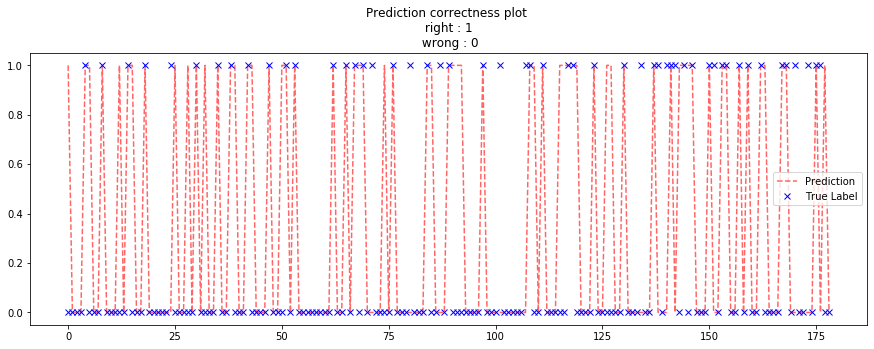

In [7]:
from matplotlib import pyplot as plt
#plt.plot(result_log[['right','wrong']])
fig=plt.figure(figsize=(15,5))
plt.plot(result_log['True Label'],'r--',alpha=0.6)
plt.plot(result_log['Predictions'],'bx')
plt.legend(['Prediction','True Label'])
plt.title('Prediction correctness plot \n right : 1 \n wrong : 0')
plt.show()

In [8]:
print('Press Enter for reduced error pruning')
accuracy=0
max_i=0
max_acc=0
best_summary = summary
accs=[]
vbs=True
for i in range(len(summary)):
        temp_rule=summary[i]
        if (len(summary[i])>4):
            temp=summary[i][-2:]
            summary[i]=summary[i][:-4]
            summary[i]=summary[i]+temp
        #print(summary[i])
        if accuracy>=max_acc:
            max_acc=accuracy
            best_summary=summary
            max_i=i
        if i==5: 
            vbs=False
            print('\n\n Skipping verbose output ...\n\n')
        accuracy,_=predict_all(test_df,test_target,summary,verbose=vbs)
        #print(accuracy)
        accs.append(accuracy)
        summary[i]=temp_rule
#print('summary',max_summary)

print('max_accuracy',max_acc)
#i  8
#max_accuracy 66.76300578034682


Press Enter for reduced error pruning
--------------------------------
179
0 precision 0.8782608695652174 recall 0.7952755905511811
1 precision 0.59375 recall 0.7307692307692307
Summary :  correct: 139 total : 179 accuracy : 77.6536312849162 %
--------------------------------
179
0 precision 0.881159420289855 recall 0.7958115183246073
1 precision 0.59375 recall 0.7354838709677419
Summary :  correct: 140 total : 179 accuracy : 78.2122905027933 %
--------------------------------
179
0 precision 0.8760869565217392 recall 0.7948717948717948
1 precision 0.59375 recall 0.7272727272727273
Summary :  correct: 137 total : 179 accuracy : 76.53631284916202 %
--------------------------------
179
0 precision 0.8782608695652174 recall 0.7952755905511811
1 precision 0.59375 recall 0.7307692307692307
Summary :  correct: 140 total : 179 accuracy : 78.2122905027933 %
--------------------------------
179
0 precision 0.8782608695652174 recall 0.7952755905511811
1 precision 0.59375 recall 0.730769230769230

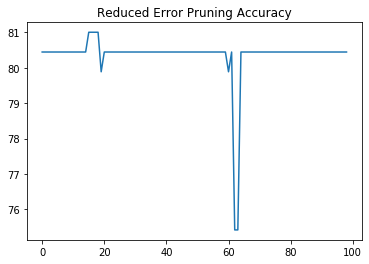

In [21]:
from matplotlib import pyplot as plt
plt.plot(np.array(accs))
plt.title('Reduced Error Pruning Accuracy')
plt.show()

In [22]:
for node in best_summary:
    for i,edge in enumerate(node):
        if i%2==0:
            print(edge,end='  ->')
        else: print(edge,end=' ')
    print('')

Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Parch  ->0 Fare  ->Fare>=0 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Parch  ->5 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Parch  ->3 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Parch  ->2 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Parch  ->1 Fare  ->Fare>=0 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age>=6.0 Parch  ->4 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->S Age  ->Age<6.0 Survived  ->1 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->Q Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->1 Embarked  ->C Parch  ->1 Age  ->Age>=6.0 Fare  ->Fare>=0 Survived  ->1 
Sex  ->male Pclass  ->3 SibSp  ->1 Parch  ->0 Age  ->Age>=6.0 Fare  ->Fare>=0 Survived  ->0 
Sex  ->male Pclass  ->3 SibSp  ->0 Parch  ->0 Embarked  ->S Fare  ->Fare>=0 Age